# Sentiment Analysis

## Import necessary modules

In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

## Import Data

In [2]:
data = pd.DataFrame()
data = pd.read_csv('C:\\Users\\DELL\\Desktop\\sentiment.tsv', sep='\t')
data.columns = ['sentiment', 'text']

# Check unique sentiments
print(data['sentiment'].unique())

['pos' 'neg']


Positive words


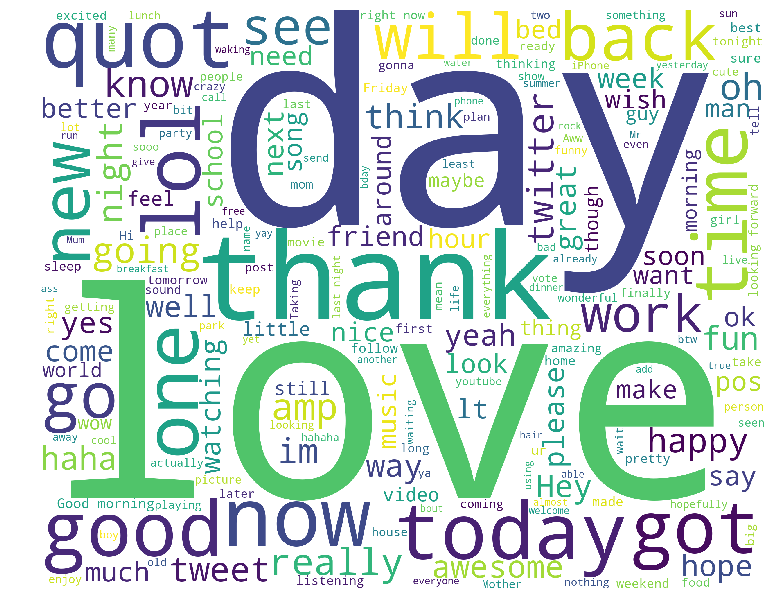

Negative words


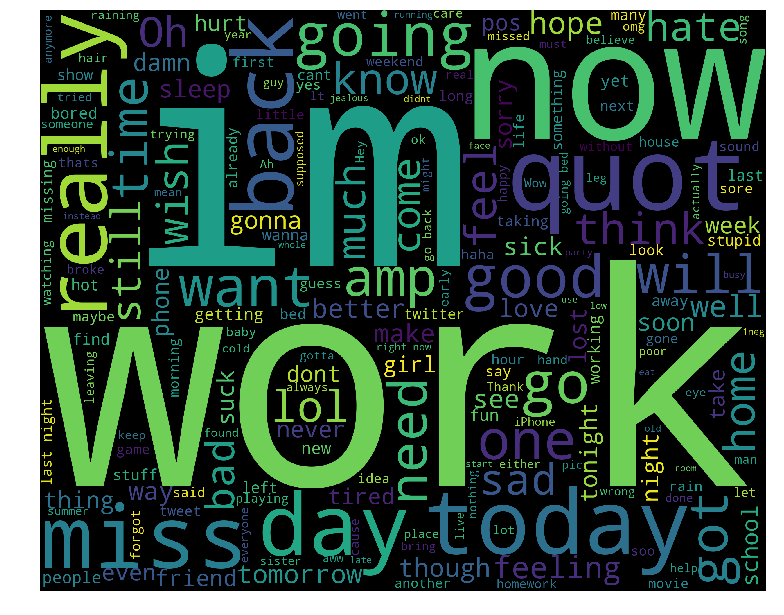

In [3]:
# Split the data per unique sentiments
data_pos = data[data['sentiment'] == 'pos']['text']
data_neg = data[data['sentiment'] == 'neg']['text']

# Function for displaying wordcloud
def wordcloud_draw(data, color):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(data_pos, 'white')
print("Negative words")
wordcloud_draw(data_neg, 'black')

## Splitting the dataset into train and test set

In [4]:
# Split dataset into train and test per unique sentiment
train, test = train_test_split(data, test_size = 0.1)

## Removing Stopwords

In [5]:
tweets_train = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets_train.append((words_without_stopwords, row.sentiment))

tweets_test = []
for index, row in test.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets_test.append((words_without_stopwords, row.sentiment))

## Extracting word features

Word Features


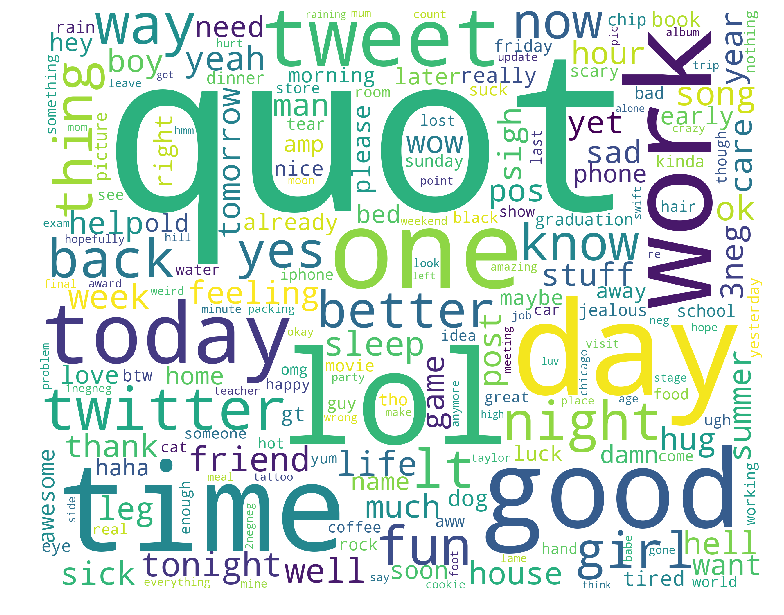

In [6]:
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(get_words_in_tweets(tweets_train))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

print('Word Features')
wordcloud_draw(w_features, 'white')

## Training the Naive Bayes classifier

In [7]:
training_set = nltk.classify.apply_features(extract_features,tweets_train)
testing_set = nltk.classify.apply_features(extract_features,tweets_test)
classifier = nltk.NaiveBayesClassifier.train(training_set)

## Testing the Naive Bayes classifier

In [8]:
test_result = []
gold_result = []

for i in range(len(testing_set)):
    test_result.append(classifier.classify(testing_set[i][0]))
    gold_result.append(testing_set[i][1])

## Get the metrics

In [28]:
CM = nltk.ConfusionMatrix(gold_result, test_result)
print(CM)

print("Naive Bayes Algo accuracy percent:"+str((nltk.classify.accuracy(classifier, testing_set))*100))
print("\nClasification report:\n", classification_report(gold_result, test_result))

TN = CM._confusion[0][0]
FN = CM._confusion[0][1]
FP = CM._confusion[1][0]
TP = CM._confusion[1][1]
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

T = TP / (TP + FN)
U = TN / (FP + TN)

auc = (T + U) / 2
print("AUC :", auc)

    |  n  p |
    |  e  o |
    |  g  s |
----+-------+
neg |<64>46 |
pos | 25<65>|
----+-------+
(row = reference; col = test)

Naive Bayes Algo accuracy percent:64.5

Clasification report:
               precision    recall  f1-score   support

         neg       0.72      0.58      0.64       110
         pos       0.59      0.72      0.65        90

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.64       200
weighted avg       0.66      0.65      0.64       200

AUC : 0.6523433545905456
